# Recursive Stratified Sampling if Monte Carlo Estimate

This example uses a recursive stratified sampling Monte-Carlo method to numerically integrate a function defined in Cartesian coordinates over the area of a unit circle defined in polar coordinates. 

## Author
J. Bott




The variance for a partition is calculated as the sum of the ratio between variance and number of samples for each partition:

$$ Var(f) = \frac{\sigma^2_a(f)}{4Na} + \frac{\sigma^2_a(f)}{4Nb} $$

The expectation is calculated as the mean of the expected value for each partition:

$$ E(f) = \frac{1}{2}\left(E_a(f) + E_b(f)\right) $$



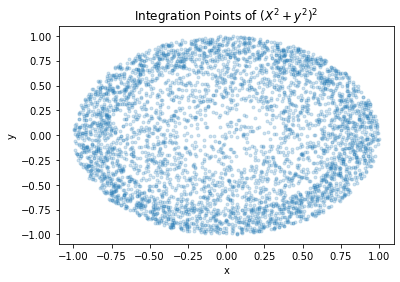

,theta,r,value,x,y
0,1.999756,0.993753,0.975247,-0.413326,0.903718
1,3.082815,0.996250,0.985083,-0.994529,0.058524
2,5.344559,0.992362,0.969795,0.586383,-0.800585
3,4.947241,0.994541,0.978341,0.231429,-0.967239
4,3.089236,0.995412,0.981774,-0.994048,0.052093
...,...,...,...,...,...
95,5.324660,0.223469,0.002494,0.128434,-0.182875
96,4.167654,0.237795,0.003198,-0.123224,-0.203378
97,2.000371,0.093382,0.000076,-0.038892,0.084898
98,4.908219,0.143199,0.000420,0.027864,-0.140462


In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def f(theta, r):
    """ The function to integrate. """
    # Convert to rectangular coordinates
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    
    # Evaluate result
    return (x**2 + y**2)**2 


def half(t):
    """ Finds radius which divides an annulus into two equal volumes.  """
    return np.sqrt((t[1]**2)/2 + (t[0]**2)/2)

def rss_polar(N, k, boundTheta, boundR, maxError, maxDepth, depth=1):
    """ Recursive stratified sampling implementation. """
    
    # Sample k points
    if(depth >= maxDepth
      or N <= 4):
        nThisDraw = N
    else:
        nThisDraw = 100
    
    # Generate sample points
    dfPoints = pd.DataFrame(
        columns = ("theta", "r"), 
        data = np.random.uniform((boundTheta[0],boundR[0]**2), (boundTheta[1],boundR[1]**2), (k, 2)))
    
    # Transform R for evenly distributed density of points along radius
    dfPoints["r"] = np.sqrt(dfPoints["r"])
    
    # User numpy vectorize rather than pandas apply to increase speed 
    dfPoints["value"] = np.vectorize(f)(dfPoints["theta"], dfPoints["r"])
    
    # Points in circle
    V = (boundR[1]**2)*(abs(boundTheta[1] - boundTheta[0])/2) - (boundR[0]**2)*(abs(boundTheta[1] - boundTheta[0])/2)

    # Calculate the mean, variance and error
    mean = dfPoints["value"].mean()
    variance = dfPoints["value"].var()
    error = np.sqrt(variance / dfPoints.shape[0]) * V

    # If error nor acceptable and max depth not reached
    if(error > maxError 
      and depth < maxDepth
      and N > 4):   
        df1 = dfPoints[dfPoints["theta"] > np.mean(boundTheta)] 
        df2 = dfPoints[dfPoints["theta"] <= np.mean(boundTheta)]
        df3 = dfPoints[dfPoints["r"] > half(boundR)]
        df4 = dfPoints[dfPoints["r"] <= half(boundR)]
        
        if(df1.shape[0] > 0
          and df2.shape[0] > 0
          and df3.shape[0] > 0
          and df4.shape[0] > 0):

            var1 = df1["value"].var()/(4*df1.shape[0]) + df2["value"].var()/(4*df2.shape[0])
            var2 = df3["value"].var()/(4*df3.shape[0]) + df4["value"].var()/(4*df4.shape[0])
            var1 = df1["value"].var()/(4*df1.shape[0]) + df2["value"].var()/(4*df2.shape[0])
            var2 = df3["value"].var()/(4*df3.shape[0]) + df4["value"].var()/(4*df4.shape[0])

            # Split along x direction
            if(var1 < var2):  
                Na = int(N*np.sqrt(df1["value"].var())/(np.sqrt(df1["value"].var())+np.sqrt(df2["value"].var())))
                Nb = N - Na
                if(Na > 0):
                    valueSub1, varianceSub1, dfPointsSub1 = rss(Na, k, (np.mean(boundTheta), boundTheta[1]), boundR, maxError, maxDepth, depth+1)
                else:
                    valueSub1 = varianceSub1 = dfPointsSub1 = None
                if(Nb > 0):
                    valueSub2, varianceSub2, dfPointsSub2 = rss(Nb, k, (boundTheta[0], np.mean(boundTheta)), boundR, maxError, maxDepth, depth+1)
                else:
                    valueSub2 = varianceSub2 = dfPointsSub2 = None
            # Else split along y direction
            else:
                Na = int(N*np.sqrt(df3["value"].var())/(np.sqrt(df3["value"].var())+np.sqrt(df4["value"].var())))
                Nb = N - Na
                if(Na > 0):
                    valueSub1, varianceSub1, dfPointsSub1 = rss_polar(Na, k, boundTheta, (half(boundR), boundR[1]), maxError, maxDepth, depth+1)
                else:
                    valueSub1 = varianceSub1 = dfPointsSub1 = None
                if(Nb > 0):
                    valueSub2, varianceSub2, dfPointsSub2 = rss_polar(Nb, k, boundTheta, (boundR[0], half(boundR)), maxError, maxDepth, depth+1)
                else:
                    valueSub2 = varianceSub2 = dfPointsSub2 = None
            
            if(Na == 0 or Nb == 0):
                raise RuntimeError(f"Failure Na:{Na} Nb:{Nb}")
            
            # Final estimate
            varianceFinal = (Na*varianceSub1 + Na*varianceSub2)/(Na + Nb)
            valueFinal = valueSub1 + valueSub2
            dfPointsFinal = pd.concat([dfPointsSub1, dfPointsSub2], axis=0)
                
            return valueFinal, varianceFinal, dfPointsFinal
        
    # Return final values
    return dfPoints["value"].mean()*V, dfPoints["value"].var(), dfPoints
    
# Maximum number of sample points
N = 100000
boundTheta = (0, 2*np.pi)
boundR = (0, 1)
maxError = 0.0001
maxDepth = 10

calculatedIntegral, varianceValue, df = rss_polar(N, 100, boundTheta, boundR, maxError, maxDepth)

# Transform the data
df["x"] = df["r"]*np.cos(df["theta"])
df["y"] = df["r"]*np.sin(df["theta"])

plt.scatter(df["x"], df["y"], marker='.', alpha=0.2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Integration Points of $(X^2+y^2)^2$")
plt.show()

df

In [8]:
# Calculate the estimated error
error = np.sqrt(varianceValue/N)*np.pi

# Analytical solution of the integral
analyticalIntegral = np.pi/3

# Print the results 
print(f"Estimate standard error: {error}")
print(f"Calculated integral: {calculatedIntegral}")
print(f"Analytical solution: {analyticalIntegral}")
print(f"Percent error is: {(100*(calculatedIntegral-analyticalIntegral)/analyticalIntegral):.4f} %")


Estimate standard error: 9.901113551721135e-05
Calculated integral: 1.047835056635562
Analytical solution: 1.0471975511965976
Percent error is: 0.0609 %
